In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential

In [2]:
train_dir='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

## Mohamed Shakshak

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 224
img_width = 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' 
)

# Create the validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


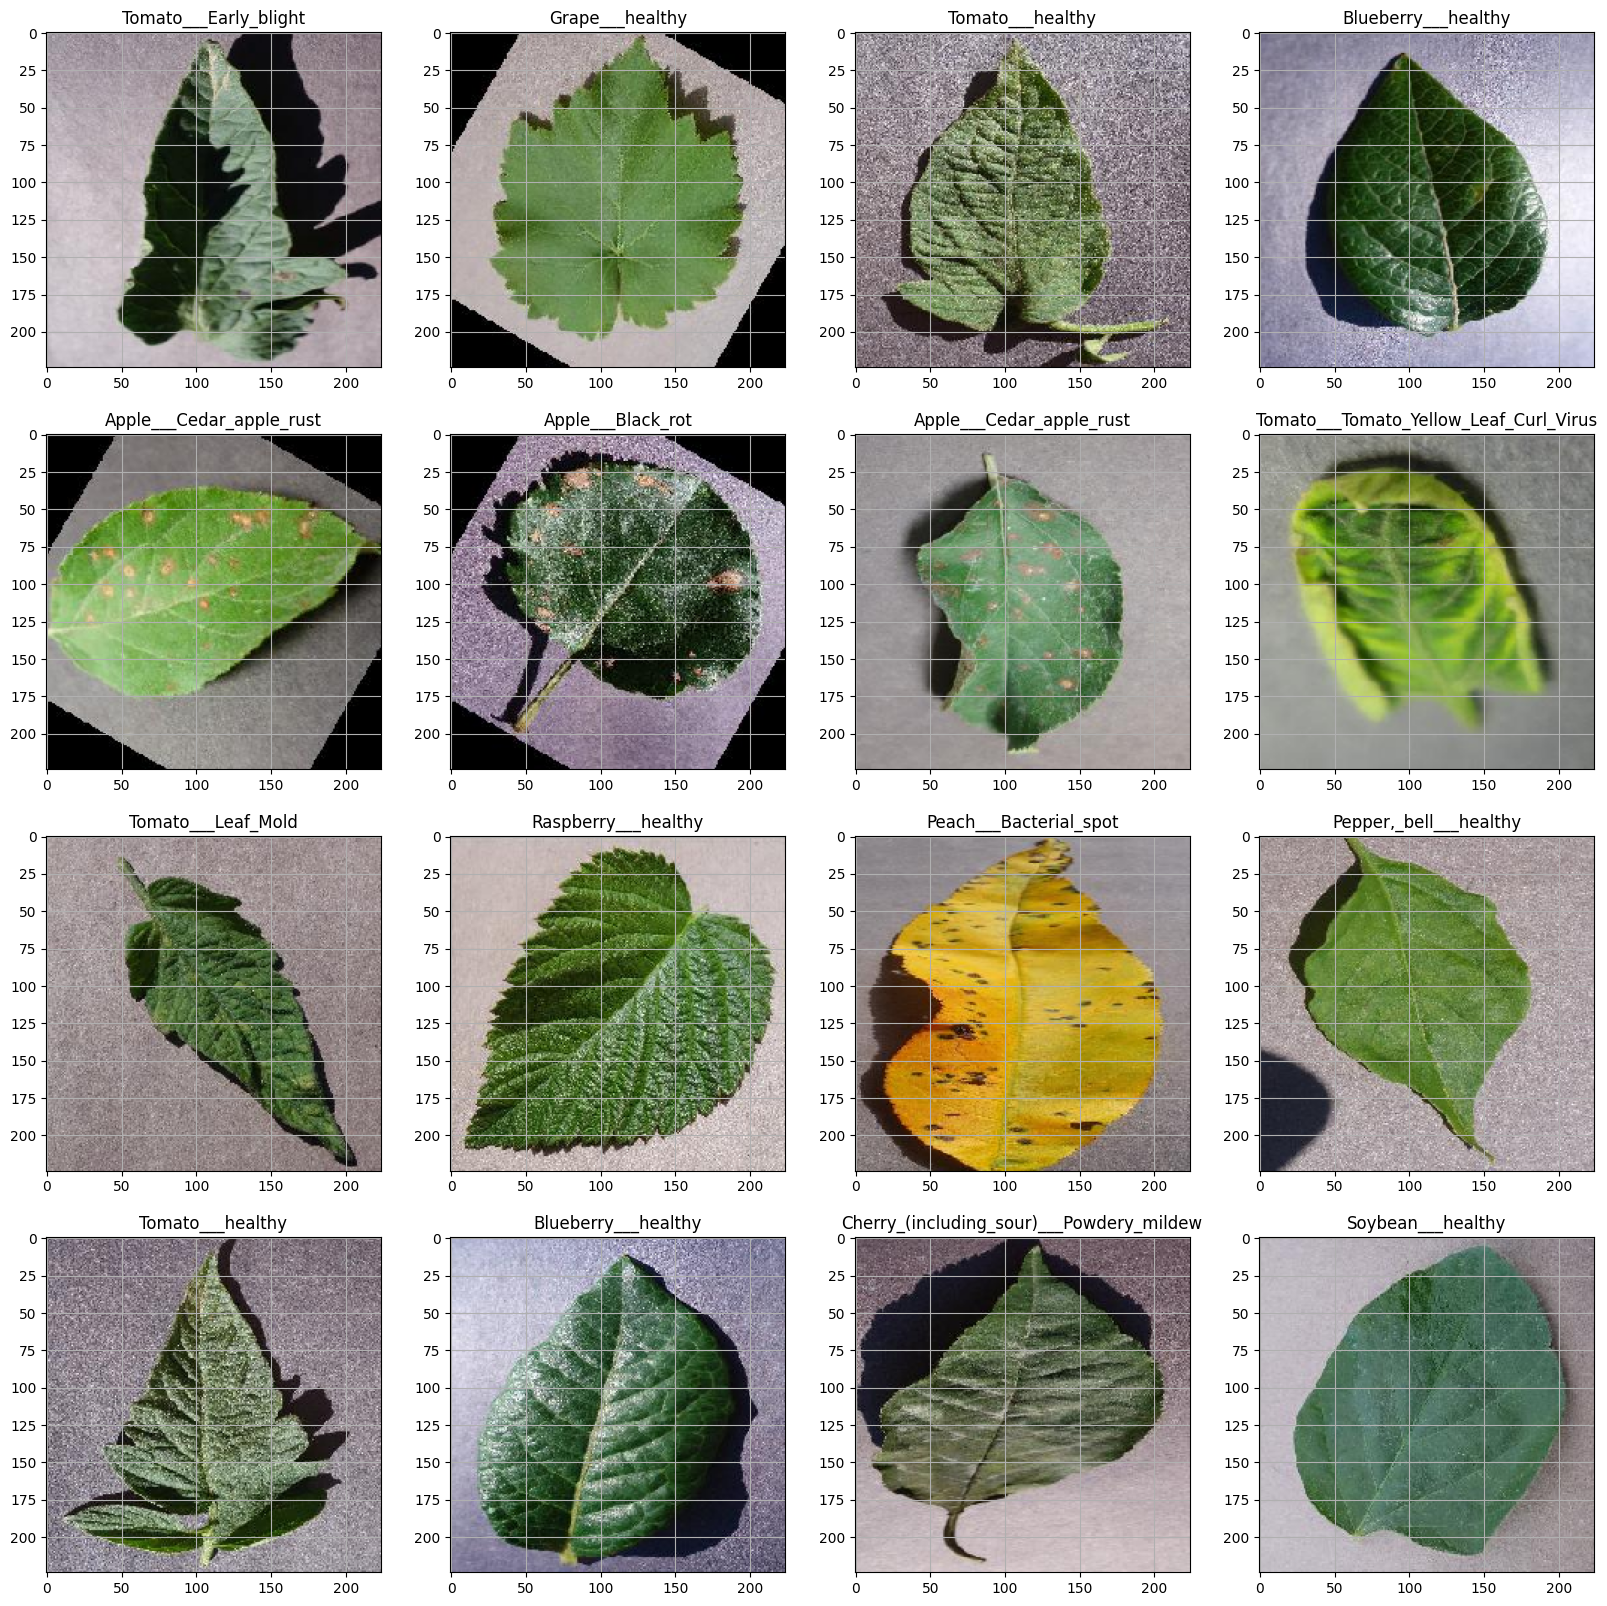

In [4]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch  , y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse 
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [5]:
test_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 17572 images belonging to 38 classes.


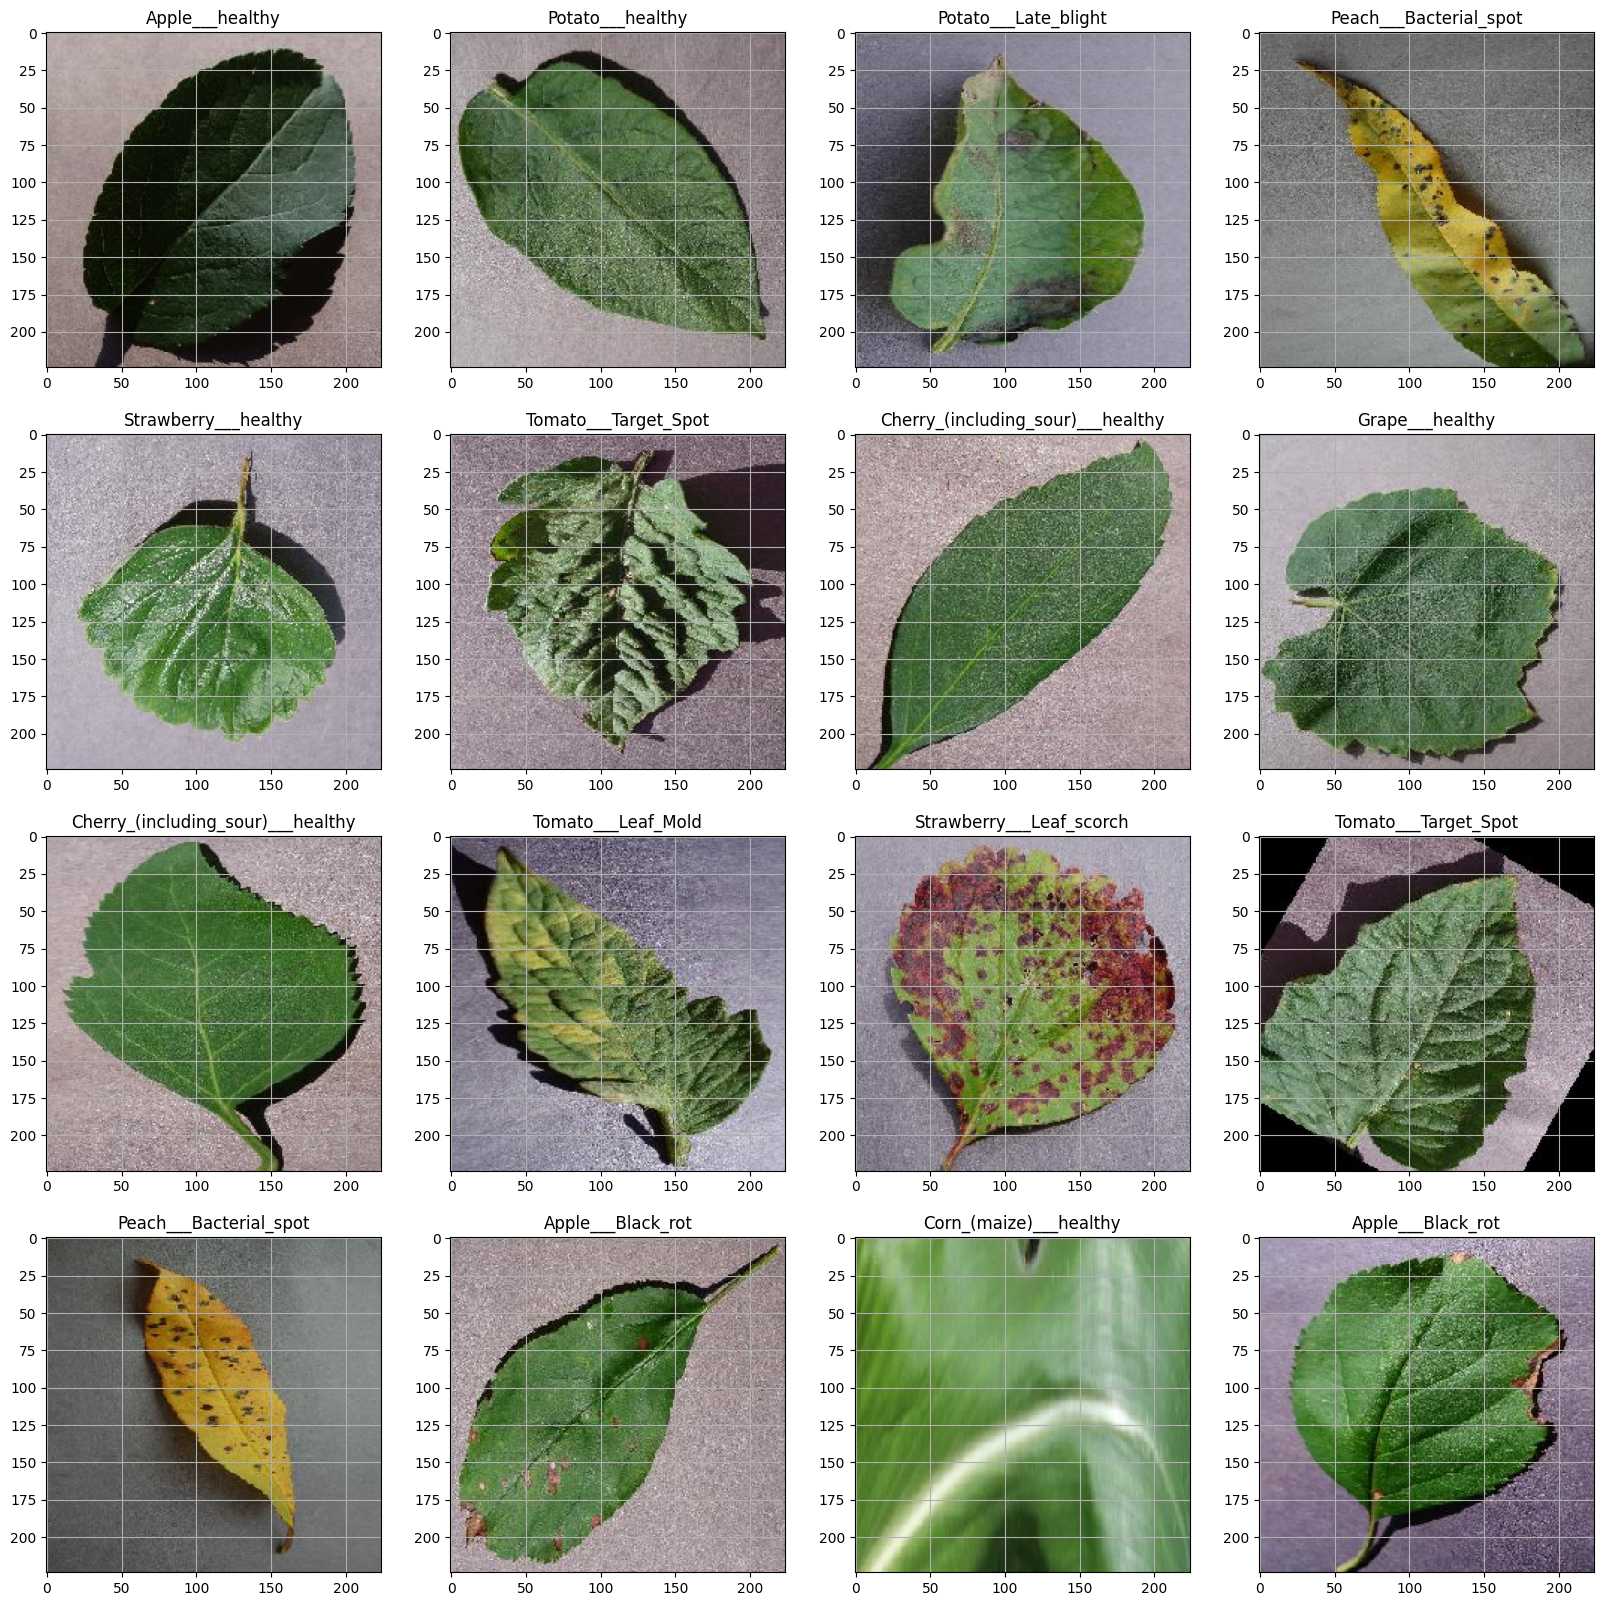

In [7]:
classes=list(val_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in val_generator:
    # create a grid of 3x3 imag
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        # plt.title(classes[int(y_batch[i])])   # when y is binary or sparse 
        plt.grid(None)
    # show the plot
    plt.show()
    break

In [8]:
metrics = [
    'accuracy',
    Precision(),
    Recall(),
]

In [9]:
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Define hyperparameters

CNN_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')  
])

epochs = 50

# Transfer Learning with VGG16
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model_vgg19.layers[-4:]:  # Choose the last 4 layers to unfreeze, can be adjusted
    layer.trainable = True

# Define the model architecture
model_vgg19 = models.Sequential([
    base_model_vgg19,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])


# Transfer Learning with ResNet50
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model_resnet50.layers[-10:]:
    layer.trainable = True
    
model_resnet50 = models.Sequential([
    base_model_resnet50,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

# Transfer Learning with InceptionV3
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model_inceptionv3.layers[:-30]:
    layer.trainable = False

model_inceptionv3 = models.Sequential([
    base_model_inceptionv3,
     GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)


In [11]:
model_vgg19.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics= metrics
)

In [12]:
model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics= metrics
)

In [13]:
model_inceptionv3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

In [15]:
def evaluate_model(model, train_gen, valid_gen, test_gen):
    # Evaluate the model on the training data generator
    model_eval_train = model.evaluate(train_gen)
    print('Training Data:')
    print('Loss:      ', model_eval_train[0])
    print('Accuracy:  ', model_eval_train[1])
    print('Precision: ', model_eval_train[2])
    print('Recall:    ', model_eval_train[3])
    
    # Evaluate the model on the validation data generator
    model_eval_valid = model.evaluate(valid_gen)
    print('\nValidation Data:')
    print('Loss:      ', model_eval_valid[0])
    print('Accuracy:  ', model_eval_valid[1])
    print('Precision: ', model_eval_valid[2])
    print('Recall:    ', model_eval_valid[3])
    
    # Evaluate the model on the test data generator
    model_eval_test = model.evaluate(test_gen)
    print('\nTest Data:')
    print('Loss:      ', model_eval_test[0])
    print('Accuracy:  ', model_eval_test[1])
    print('Precision: ', model_eval_test[2])
    print('Recall:    ', model_eval_test[3])
    
    return (np.round(model_eval_train[0], 2), np.round(model_eval_valid[0], 2), np.round(model_eval_test[0], 2),
            np.round(model_eval_train[1], 2), np.round(model_eval_valid[1], 2), np.round(model_eval_test[1], 2),
            np.round(model_eval_train[2], 2), np.round(model_eval_valid[2], 2), np.round(model_eval_test[2], 2),
            np.round(model_eval_train[3], 2), np.round(model_eval_valid[3], 2), np.round(model_eval_test[3], 2),)

In [16]:
history_cnn = CNN_model.fit(train_generator, epochs=epochs, validation_data=val_generator ,  callbacks = callbacks)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729967407.819064      89 service.cc:145] XLA service 0x7aef68004750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729967407.819145      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/879 ━━━━━━━━━━━━━━━━━━━━ 52s 60ms/step - accuracy: 0.0273 - loss: 3.8068 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1729967415.786546      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


879/879 ━━━━━━━━━━━━━━━━━━━━ 379s 417ms/step - accuracy: 0.3331 - loss: 2.4047 - precision: 0.7044 - recall: 0.1963 - val_accuracy: 0.8219 - val_loss: 0.5878 - val_precision: 0.8996 - val_recall: 0.7400 - learning_rate: 0.0010
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 175s 198ms/step - accuracy: 0.7688 - loss: 0.7438 - precision: 0.8527 - recall: 0.6932 - val_accuracy: 0.8809 - val_loss: 0.3678 - val_precision: 0.9249 - val_recall: 0.8421 - learning_rate: 0.0010
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 173s 195ms/step - accuracy: 0.8558 - loss: 0.4562 - precision: 0.8998 - recall: 0.8162 - val_accuracy: 0.9181 - val_loss: 0.2549 - val_precision: 0.9371 - val_recall: 0.9021 - learning_rate: 0.0010
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 176s 199ms/step - accuracy: 0.8921 - loss: 0.3379 - precision: 0.9201 - recall: 0.8680 - val_accuracy: 0.9269 - val_loss: 0.2186 - val_precision: 0.9424 - val_recall: 0.9137 - learning_rate: 0.0010
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - a

In [17]:
# Train the models
history_vgg19 = model_vgg19.fit(train_generator, epochs=epochs, validation_data=val_generator ,  callbacks = callbacks)

Epoch 1/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 521s 545ms/step - accuracy: 0.3449 - loss: 2.4404 - precision: 0.9052 - recall: 0.5343 - val_accuracy: 0.9115 - val_loss: 0.3023 - val_precision: 0.9495 - val_recall: 0.8710 - learning_rate: 1.0000e-05
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 440s 499ms/step - accuracy: 0.8691 - loss: 0.4483 - precision: 0.9181 - recall: 0.8256 - val_accuracy: 0.9511 - val_loss: 0.1673 - val_precision: 0.9668 - val_recall: 0.9334 - learning_rate: 1.0000e-05
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 442s 501ms/step - accuracy: 0.9316 - loss: 0.2281 - precision: 0.9515 - recall: 0.9120 - val_accuracy: 0.9685 - val_loss: 0.1027 - val_precision: 0.9768 - val_recall: 0.9603 - learning_rate: 1.0000e-05
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 441s 501ms/step - accuracy: 0.9529 - loss: 0.1581 - precision: 0.9651 - recall: 0.9407 - val_accuracy: 0.9789 - val_loss: 0.0663 - val_precision: 0.9818 - val_recall: 0.9754 - learning_rate: 1.0000e-05
Epoch 5/50
879/879 ━━━━━━━━━━━━━

In [18]:
history_resnet50 = model_resnet50.fit(train_generator, epochs=epochs, validation_data=val_generator,  callbacks = callbacks)

Epoch 1/50


I0000 00:00:1729987835.994560      87 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 16 bytes spill stores, 16 bytes spill loads



661/879 ━━━━━━━━━━━━━━━━━━━━ 59s 274ms/step - accuracy: 0.3374 - loss: 2.6795 - precision: 0.9820 - recall: 0.5683

I0000 00:00:1729988047.942768      87 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 16 bytes spill stores, 16 bytes spill loads



879/879 ━━━━━━━━━━━━━━━━━━━━ 380s 358ms/step - accuracy: 0.4111 - loss: 2.3800 - precision: 0.9774 - recall: 0.5709 - val_accuracy: 0.3892 - val_loss: 2.4742 - val_precision: 0.6043 - val_recall: 0.2903 - learning_rate: 1.0000e-05
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 310s 314ms/step - accuracy: 0.9422 - loss: 0.2204 - precision: 0.9670 - recall: 0.9133 - val_accuracy: 0.9771 - val_loss: 0.0736 - val_precision: 0.9824 - val_recall: 0.9724 - learning_rate: 1.0000e-05
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 276s 313ms/step - accuracy: 0.9785 - loss: 0.0826 - precision: 0.9852 - recall: 0.9708 - val_accuracy: 0.9856 - val_loss: 0.0485 - val_precision: 0.9879 - val_recall: 0.9842 - learning_rate: 1.0000e-05
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 323s 314ms/step - accuracy: 0.9907 - loss: 0.0383 - precision: 0.9933 - recall: 0.9881 - val_accuracy: 0.9866 - val_loss: 0.0439 - val_precision: 0.9878 - val_recall: 0.9861 - learning_rate: 1.0000e-05
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 277

In [19]:
history_inceptionv3 = model_inceptionv3.fit(train_generator, epochs=epochs, validation_data=val_generator ,  callbacks = callbacks)

Epoch 1/50
  2/879 ━━━━━━━━━━━━━━━━━━━━ 1:12 83ms/step - accuracy: 0.0273 - loss: 3.9536 - precision: 0.9921 - recall: 0.9845  

I0000 00:00:1729990839.172675      89 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_12', 12 bytes spill stores, 24 bytes spill loads



636/879 ━━━━━━━━━━━━━━━━━━━━ 49s 205ms/step - accuracy: 0.1903 - loss: 3.1950 - precision: 0.9902 - recall: 0.4759

I0000 00:00:1729990969.090327      90 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_12', 12 bytes spill stores, 24 bytes spill loads



879/879 ━━━━━━━━━━━━━━━━━━━━ 244s 251ms/step - accuracy: 0.2444 - loss: 2.9975 - precision: 0.9862 - recall: 0.4264 - val_accuracy: 0.7605 - val_loss: 1.1499 - val_precision: 0.9703 - val_recall: 0.4306 - learning_rate: 1.0000e-05
Epoch 2/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 179s 202ms/step - accuracy: 0.6928 - loss: 1.2062 - precision: 0.9172 - recall: 0.4356 - val_accuracy: 0.8370 - val_loss: 0.6512 - val_precision: 0.9505 - val_recall: 0.6834 - learning_rate: 1.0000e-05
Epoch 3/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 178s 201ms/step - accuracy: 0.7946 - loss: 0.7593 - precision: 0.9193 - recall: 0.6499 - val_accuracy: 0.8688 - val_loss: 0.4753 - val_precision: 0.9443 - val_recall: 0.7770 - learning_rate: 1.0000e-05
Epoch 4/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 183s 207ms/step - accuracy: 0.8452 - loss: 0.5601 - precision: 0.9288 - recall: 0.7487 - val_accuracy: 0.8888 - val_loss: 0.3832 - val_precision: 0.9467 - val_recall: 0.8243 - learning_rate: 1.0000e-05
Epoch 5/50
879/879 ━━━━━━━━━━━━━━━━━━━━ 205

In [20]:
Final_report = []

In [21]:
Final_report.append(evaluate_model(CNN_model, train_generator, val_generator, test_generator))
Final_report.append(evaluate_model(model_vgg19, train_generator, val_generator, test_generator))
Final_report.append(evaluate_model(model_resnet50, train_generator, val_generator, test_generator))
Final_report.append(evaluate_model(model_inceptionv3, train_generator, val_generator, test_generator))


879/879 ━━━━━━━━━━━━━━━━━━━━ 143s 163ms/step - accuracy: 0.9977 - loss: 0.0090 - precision: 0.9978 - recall: 0.9976
Training Data:
Loss:       0.009231379255652428
Accuracy:   0.9976178407669067
Precision:  0.9976528882980347
Recall:     0.9974578022956848
220/220 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.9597 - loss: 0.1435 - precision: 0.9635 - recall: 0.9581

Validation Data:
Loss:       0.1491004079580307
Accuracy:   0.9582027792930603
Precision:  0.9613401889801025
Recall:     0.9561378359794617
275/275 ━━━━━━━━━━━━━━━━━━━━ 128s 465ms/step - accuracy: 0.9601 - loss: 0.1339 - precision: 0.9644 - recall: 0.9573

Test Data:
Loss:       0.1334078460931778
Accuracy:   0.959822416305542
Precision:  0.9637332558631897
Recall:     0.9572615623474121
879/879 ━━━━━━━━━━━━━━━━━━━━ 146s 166ms/step - accuracy: 0.9998 - loss: 5.4023e-04 - precision: 0.9998 - recall: 0.9998
Training Data:
Loss:       0.0004545506089925766
Accuracy:   0.9998577833175659
Precision:  0.999875545501709
Recal

In [22]:
Model_Names = ['CNN_model','VGG19', 'ResNet50', 'InceptionV3']

In [23]:
Model_Accuracy = pd.DataFrame(
    Final_report,
    index=Model_Names,
    columns=[
        'Train Loss', 'Validation Loss', 'Test Loss',
        'Train Accuracy', 'Validation ACC', 'Test ACC',
        'Train Precision', 'Validation Precision', 'Test Precision',
        'Train Recall', 'Validation Recall', 'Test Recall',
    ]
)

In [24]:
Model_Accuracy

Train Loss  Validation Loss  Test Loss  Train Accuracy  \
CNN_model          0.01             0.15       0.13            1.00   
VGG19              0.00             0.02       0.02            1.00   
ResNet50           2.40             2.47       2.44            0.40   
InceptionV3        1.09             1.15       1.14            0.79   

             Validation ACC  Test ACC  Train Precision  Validation Precision  \
CNN_model              0.96      0.96             1.00                  0.96   
VGG19                  1.00      1.00             1.00                  1.00   
ResNet50               0.39      0.40             0.63                  0.60   
InceptionV3            0.76      0.77             0.97                  0.97   

             Test Precision  Train Recall  Validation Recall  Test Recall  
CNN_model              0.96          1.00               0.96         0.96  
VGG19                  1.00          1.00               1.00         1.00  
ResNet50               0.61          0.31               0.29         0.30  
InceptionV3            0.97          0.44               0.43         0.43

In [25]:
Model_Accuracy.to_csv('Report.csv', index = True)